### Import

In [3]:
import numpy as np
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import random


### Functions

In [4]:
def compute_P_matrix(A):
    w = compute_w(A)
    D = np.diag(w)
    P = np.linalg.inv(D)@A
    return P

def compute_pi(P):
    values, vectors = np.linalg.eig(P.T)
    index = np.argmax(values.real)
    pi = vectors[:,index].real
    pi = pi/pi.sum()
    return pi

def compute_w(A):
    w = np.sum(A, axis=1)
    return w

def compute_Q_matrix(A):
    w = compute_w(A)
    w_star = np.argmax(w)
    Q = A/w_star
    Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
    return Q

def initialize_pos_ttimes(n_particles):
    pos = [ [] for _ in range(n_particles)]
    ttimes = [ [] for _ in range(n_particles)]
    return pos, ttimes

## Exercise 1

The first part of this assignment consists in studying a single particle performing a continuous-time random walk in the network described by the graph in Fig. 1 and with the following transition rate matrix:

$$
\Lambda = 
\begin{pmatrix}
0 & 2/5 & 1/5 & 0 & 0\\
0 & 0 & 3/4 & 1/4 & 0\\
1/2 & 0 & 0 & 1/2 & 0\\
0 & 0 & 1/3 & 0 & 2/3\\
0 & 1/3 & 0 & 1/3 & 0\\
\end{pmatrix}
\begin{matrix}
o \\ a \\ b \\ c \\ d
\end{matrix}
$$

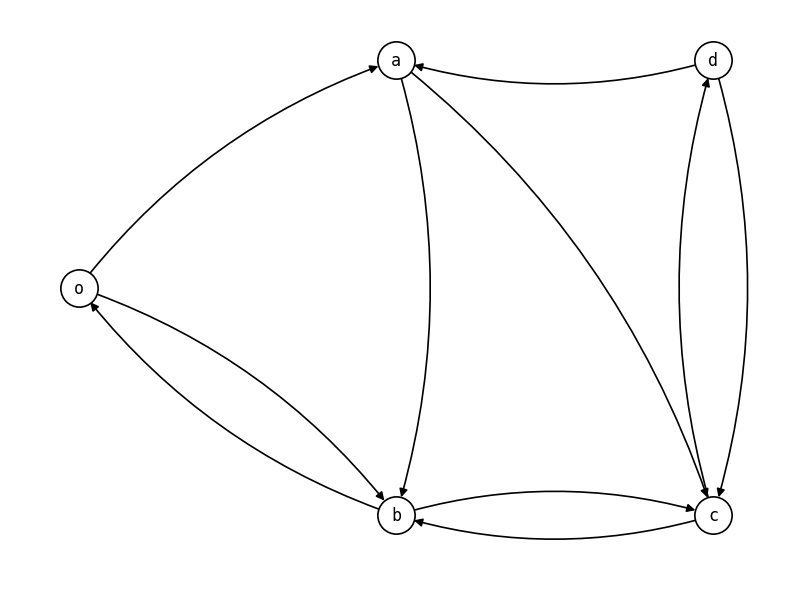

In [5]:
E = {'o':{'a':2/5,'b':1/5},'a':{'b':3/4,'c':1/4},'b':{'o':1/2,'c':1/2},'c':{'b':1/3,'d':2/3},'d':{'a':1/3,'c':1/3}}
DG = nx.DiGraph()
edge_list = [(u,v,w) for u,e in E.items() for v,w in e.items()]
DG.add_weighted_edges_from(edge_list)
indices = {n:i  for i, n in enumerate(DG.nodes) }
pos = {
    'o':[0,-1],
    'a':[2,0],
    'b':[2,-2],
    'd':[4,0],
	'c':[4,-2]
}

options = {
    "font_size": 10,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
    "font_family":"monospace"
}

plt.figure(dpi=120)
nx.draw(DG, pos, **options, with_labels=True, connectionstyle="arc3,rad=-0.15") 
plt.savefig("graph-1-compl.png")
plt.show()

In [6]:
Lambda = [
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/2, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/3, 0, 1/3, 0]
]

Q = compute_Q_matrix(Lambda)
w = compute_w(Lambda)
w_star = np.max(w)
pi_bar = compute_pi(Q)

print("pi_bar:", pi_bar)
print("Matrix Q:\n",Q)

pi_bar: [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
Matrix Q:
 [[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]


**a)** 
What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

For this simulations there are mainly two approaches:
- Using node clock with rate $\omega_i$ vector and probability matrix $P$.
- Using a global clock with $\omega_\ast$ and stochastic matrix $Q$.

### Using second approach
We are using Q and $\omega_\ast$.

We decided to use the approach with a global clock.

To simulate a Poisson clock with rate $r$, one must simulate the time between two consecutive ticks, which we denote by $t_{next}$. We can compute $t_{next}$ as

$$ t_{next} = - \frac{\ln(u)}{r}$$

where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.

**2st approach**
1. we define a unique **global** Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when we are at node $i$ and **the global clock ticks**, either you jump to a neighbor $j$ with probability $Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or we stay in the same node (no transition) with probability $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$.

In this approach, the continuous time is "discretized" using a global clock, while the matrix Q describes the jumps.

Notice that $Q_{ii}=0$ for the nodes $i$ with $\omega_i = \omega_\ast$, and it is larger as $\omega_i/\omega$ is small.

point a

In [7]:
def runtime_mc(Q, pos_init=None, pos_fin=None, n_steps=None):
    n_states = Q.shape[0]
    pos = np.zeros(1, dtype=int)
    if pos_init is None:                        #if pos_init is not given, then is choosen randomly
        pos_init = np.random.choice(n_states)
    pos[0] = pos_init
    transition_time = np.zeros(1)
    transition_time[0] = 0
    t_next = -np.log(np.random.rand())/w_star    #global clock
    pos = np.append(pos, np.random.choice(n_states,p=Q[pos[-1],:]))
    transition_time = np.append(transition_time,transition_time[-1]+t_next)
    if pos_init is not None and pos_fin is not None:                    #if we have a destination enter in this while
        while pos_fin != pos[-1]:
            pos = np.append(pos,np.random.choice(n_states,p=Q[pos[-1],:]))
            t_next = -np.log(np.random.rand())/w_star
            transition_time = np.append(transition_time,transition_time[-1]+t_next)
    else:
        while pos_init != pos[-1]:                                 #pos_fin not defined, so we finish when the particles return to pos_init
            pos = np.append(pos,np.random.choice(n_states,p=Q[pos[-1],:]))
            t_next = -np.log(np.random.rand())/w_star
            transition_time = np.append(transition_time,transition_time[-1]+t_next)
    return transition_time[-1], pos
        



For computing the average return time, we execute the experiment $100000$ times

In [8]:
n_exp = 1000
experiments = np.zeros(n_exp)
for i in range(n_exp):
    time, _  = runtime_mc(Q, 1)
    experiments[i] = time
np.average(experiments)

6.853113755424032

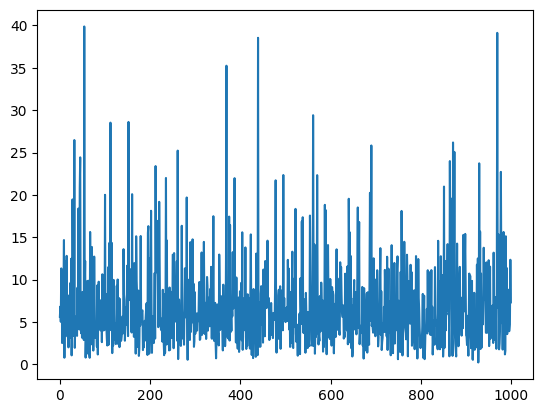

In [9]:
plt.plot(range(n_exp), experiments)

point b - theoretical expected time


From theory, we know that the expected return time:

$$
\mathbb{E}_i[T_i^+] = \frac{1}{\bar{\pi}_i\omega_i}
$$

so we compute $\mathbb{E}_a[T_a^+]$ with previous formula:

In [10]:
expected_time = 1/(w[1]*pi_bar[1])
expected_time

6.750000000000002

point c

**c)** 
What is, according to the simulations, the average time it takes to move from node $o$ to node $d$ ?

We run the same simulation of point $a$ changing initial position and destination with nodes $o$ and $d$.

In [11]:
n_exp = 100000
exper = np.zeros(n_exp)
for i in range(n_exp):
    exper[i], _ = runtime_mc(Q, 0, 4)
np.average(exper)

8.805282045554089

After $100000$ experiments the average time results near $8.8$

point d - theoretical exp. time

The formula needed to compute expected hitting time for all nodes $i$ and destination set $S = \{ d \}$ is the following:

$$
\mathbb{E}_i[T_S] = \frac{1}{\omega_i} + \sum_{j} P_{ij} \mathbb{E}_j[T_S] \quad\text{for }i \notin S 
$$

From theory, the expected hitting times  $\hat{x}= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S = \{ d \}$ and for all nodes $i \in R = \mathcal V \setminus S$ can be computed by solving the system of equations in discrete time

$$
\hat{x} = \mathbf{1} + \hat{P}\hat{x},
$$ 

where $\hat{P}$ and $\omega_p$ are obtained from $P$ and $\omega$ by removing the rows and columns corresponding to the nodes in the set $S$.

More explicitly, the expected hitting times can be expressed as

$$
\hat{x} = (I - \hat{P})^{-1} \mathbf{1}
$$

In continous time Markov Chains, we need to substitute the $\mathbf{1}$ vector with $\hat{\omega}$ that is defined as following:

$$
\hat{\omega} = \frac{1}{\omega_i} \quad \text{for all } i \notin S
$$

So the formula we use will be:

$$
\hat{x} = (I - \hat{P})^{-1} \hat{\omega}
$$

In [12]:
D = np.diag(w)
P = compute_P_matrix(Lambda)
n_states = P.shape[0]
S = [4]
R = [node for node in range(n_states) if node not in S]
index = np.ix_(R,R)
hatP = P[index]
hatP, P
wp = 1/w[np.ix_(R)]
hatx = np.linalg.inv(np.identity(hatP.shape[0]) - hatP) @ wp
print("Expected hitting time from node o to d:",hatx[0])
print("Expected time by simulating:", np.mean(exper))

Expected hitting time from node o to d: 8.785714285714285
Expected time by simulating: 8.805282045554089


As expected, the computed average times are very similar due to the large number of simulations.

In [13]:
np.linalg.inv(np.diag(w))@np.ones(w.shape).T, w, 1/w

(array([1.66666667, 1.        , 1.        , 1.        , 1.5       ]),
 array([0.6       , 1.        , 1.        , 1.        , 0.66666667]),
 array([1.66666667, 1.        , 1.        , 1.        , 1.5       ]))

point e

Interpret the matrix $\Lambda$ as the weight matrix of a graph $\mathcal{G} = (\mathcal{V},\Epsilon,\Lambda)$, and simulate the French- DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state for every initial condition x(0)? Motivate your answer.

The dynamics of $x(t)$ reads

$$
x(t+1) = Px(t),
$$

where $P$ is the normalized adjacency matrix.

Theorem:
Let $G = (V, E, Λ)$ strongly connected and aperiodic.

Then,

$$
\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},
$$

i.e., the agents get to consensus for every initial condition x(0).

In [14]:
def compute_pi(P):
    values, vectors = np.linalg.eig(P.T)
    index = np.argmax(values.real)
    pi = vectors[:,index].real
    pi = pi/pi.sum()
    return pi

In [15]:
pi = compute_pi(P)

In [16]:
pi

array([0.13043478, 0.17391304, 0.26086957, 0.26086957, 0.17391304])

This because we know that $\pi' x(t)$ is the motion invariant, so $\pi'\overline{x}$ is equal to $\pi'x(0)$

In [17]:
x_0 = np.random.uniform(0,1, len(pi))
consensus = x_0@pi
consensus

0.5413623257907088

point f

Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) = ξ_i$, where {$ξ_i$} $i\in V$ are i.i.d random variables with variance $σ^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.

Assume that state of each node represents a noisy estimate of the real state $\mu$, i.e.,

$$
x_i = \mu + y_i,
$$

with $E[y_i]=0$, and the variance $\sigma^2 (y_i) = \sigma^2$ for each $i$.


We know $\alpha = \pi' (\mu \mathbf{1} + y) = \mu + \pi'y$, then

$$
E[\alpha] = \mu + \pi' E[y] = \mu
$$

so the final estimate of the network is unbiased. Moreover,

$$
\quad \sigma_{\alpha}^2 = \sigma^2 \sum_{i} \pi_i^2 < \sigma^2,
$$

because $\sum_{i} \pi_i^2 <1$ unless the graph has a unique sink node. The interesting observation is that the estimate $\alpha$ has a smaller variance than $\sigma$, i.e., the crowd is able to reconstruct a more precise estimate of the real state than the single agents of the graph.

Compute the variance of consensus through many simulations:

In [18]:
n_exp = 10000
alpha = np.zeros(n_exp)
alpha_mean = np.zeros(n_exp)
#we run 200 experiments

for i in range(n_exp):
    x = np.random.rand(P.shape[0])
    for _ in range(500):
        x = P @ x
    alpha[i] = (1/2- np.mean(x))**2#(1/2- np.mean(x))
    alpha_mean[i] = np.mean(x)

np.mean(alpha)#, np.var(alpha_mean, dtype=np.float64)

0.01803403884723557

We now compute the variance of consensus from formula:

$$
\sigma_{\alpha}^2 = \sigma^2 \sum_{i}\pi_i^2
$$

Where the $\sigma^2$ is the variance of a Uniform Distribution, that we know is $\frac{1}{12}$

In [19]:
#x = np.random.rand(Q.shape[0])
#var = np.var(x,dtype=np.float64, ddof=1)
var_a = 1/12 * np.sum(pi**2)
var_a

0.017800882167611845

In [20]:
1/12

0.08333333333333333

As expected, both $\sigma_\alpha^2$ are smaller than $\sigma^2$.

point g

Remove the edges (d,a) and (d,c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition x(0)? Assume that the initial state of the dynamics for each node i ∈ V is given by xi(0) = ξi, where {ξi}i∈V are i.i.d random variables with variance σ2. Compute the variance of the consensus value. Motivate your answer.

The consensus value $\alpha$ is the weighted average of the initial conditions of the nodes, where the weights are given by the invariant distribution $\pi$.

The invariant distribution centrality is 0 for all the nodes that do not belong to the sink of the condensantion graph. 

Only the node "d" belong to it. So in this case  $\pi$ = [0, 0, 0, 0, 1] 

since $\pi' x(0) = \alpha$, the consensus value converge to the original opinion of agent d

the variance of the consensus value is the same of the single agents.

In [21]:
L_0 = np.array(Lambda)
L_0[-1,:] = 0
L_0[-1,-1] = 1
L_0
pi_sink = compute_pi(L_0)
pi_sink
var_a_sink = 1/12 * np.sum(pi_sink**2)
pi_sink
P_0 = compute_P_matrix(L_0)
P_0
x_0 = np.random.rand(P_0.shape[0])
x=x_0
for _ in range(500):
    x = P_0@x

print("Original opinion of agent d (sink node):", x_0[-1])
print("Consensus value of agents coincides with d's original opinion:\n", x)

Original opinion of agent d (sink node): 0.8708285707264557
Consensus value of agents coincides with d's original opinion:
 [0.87082857 0.87082857 0.87082857 0.87082857 0.87082857]


Simulate experiments to compute the variance:

In [22]:
n_exp = 10000
mu_x = 0.5
variance_x = 1/12 

alfa_err = np.zeros(n_exp)
for i in range(n_exp):
# rand returns random values in [0,1], thus \mu = 1/2
    x = np.random.rand(len(pi))
    for n in range(500):
        x = P_0 @ x
    alfa_err[i] = (mu_x - np.mean(x))**2

print("Variance of the consensus state:", np.mean(alfa_err, dtype=np.float64), "\n")

Variance of the consensus state: 0.0820282665017289 



point h

Consider the graph $(V , E , Λ)$, and remove the edges (c, b) and (d, a). Analyse the French- DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition x(0).


Removing $(c,b)$ and $(d,a)$ we obtain a new sink in the condensation graph with nodes $c$ and $d$.

The induced subgraph on $d,c$ is periodic so they not reach consensus.
Conversely, the other nodes are negligible for the consensus value so the graph not reach consensus.

In [23]:
L_h = np.array(Lambda)
L_h[3,2] = 0
L_h[4,1] = 0

P_h = compute_P_matrix(L_h)
x_0 = np.random.rand(P_h.shape[0])
x = x_0
for _ in range(500):
    x = P_h @ x

print("Initial condition:", x_0)
print("Mean of opinion of the sink nodes:",(x_0[-1]+x_0[-2])/2)
print("Opinion after 500 iterations:", x)
print("Repeat the experiment for a larger number of iterations:")
x_0 = np.random.rand(len(pi))
x = x_0 
for n in range(10000*2):
    x = P_h @ x
print("Initial condition:", x_0)
print("Mean of opinion of the sink nodes:",(x_0[-1]+x_0[-2])/2)
print("Opinion after 20000 iterations:", x)

Initial condition: [0.20537833 0.79343717 0.032456   0.2640205  0.37577448]
Mean of opinion of the sink nodes: 0.31989749304422765
Opinion after 500 iterations: [0.31559926 0.31130103 0.3499851  0.2640205  0.37577448]
Repeat the experiment for a larger number of iterations:
Initial condition: [0.52929087 0.09042712 0.35886977 0.6593235  0.79919569]
Mean of opinion of the sink nodes: 0.7292595983057601
Opinion after 20000 iterations: [0.7238799  0.7185002  0.7669175  0.6593235  0.79919569]


## Exercise 2


**a)**

Particle perspective

Based on same graph in Exercise 1:

> *If 100 particles all start in node a, what is the average time for a particle to return to node a?*

In [24]:
def simulationParticlesPerspective(P, w, starting_node, destination_node, nparticles):
    nstates = P.shape[0]
    pos, ttimes = initialize_pos_ttimes(nparticles)
    for i in range(len(pos)):
        pos[i] = np.append(pos[i], starting_node)
    cp = 0
    for i in range(nparticles):
        cstate = int(pos[i][-1])
        pos[i]= np.append(pos[i],np.random.choice(nstates, p=P[int(pos[i][-1]),:]))
        ttimes[i] = np.append(ttimes[i], -np.log(np.random.rand())/w[cstate])

    while cp != nparticles:
        cp = 0
        for i in range(nparticles):
            if  pos[i][-1] == destination_node:
                cp+=1
                pass
            else:
                cstate = int(pos[i][-1])
                pos[i]= np.append(pos[i],np.random.choice(nstates, p=P[int(pos[i][-1]),:]))
                ttimes[i] = np.append(ttimes[i], ttimes[i] -np.log(np.random.rand())/w[cstate])
    
    return pos, ttimes

In [25]:
pp, tt = simulationParticlesPerspective(P, w, starting_node=1, destination_node=1, nparticles=100)
mean_time = [ row[-1] for row in iter(tt)]
np.mean(mean_time)

6.829451335554178

In [26]:
experiments = np.array([],dtype=np.float64)

In [27]:
experiments

array([], dtype=float64)

In [28]:
#repeat the experiment 100 times
for i in range(10):
    pp, tt = simulationParticlesPerspective(P, w, starting_node=1, destination_node=1, nparticles=100)
    mean_time = [ row[-1] for row in iter(tt)]
    experiments = np.append(experiments,np.mean(mean_time))
np.mean(experiments)

6.574960958892083

Considering that each particle is independent from others, the average time to return is equal to experiment run in Exercise 1 with a single particle.
The average time is $\simeq$ 6.71

*Node Perspective*

In [29]:
def simulationNodePerspective(P, w_star, starting_node, nparticles, max_time):
    nstates = P.shape[0]
    nparticles_node = [0] * nstates
    nparticles_node[starting_node] = nparticles
    #nparticles_node = [100 if i == starting_node else 0 for i in range(nstates) ]
    ttimes = [0]
    nparticles_times = [nparticles_node.copy()]
    t_next = -np.log(np.random.rand())/(w_star*nparticles)
    ttimes = np.append(ttimes, ttimes[-1] + t_next)

    while ttimes[-1] < max_time:
        prob = [nparticles_node[i]/100 for i in range(nstates)]
        from_node = np.random.choice(nstates, p=prob)
        nparticles_node[from_node] -= 1
        to_node = np.random.choice(nstates, p=P[from_node,:])
        nparticles_node[to_node] += 1
        nparticles_times.append(nparticles_node.copy())
        t_next = -np.log(np.random.rand())/(w_star*nparticles)
        ttimes = np.append(ttimes, ttimes[-1] + t_next)
    return ttimes[:-1], nparticles_times

In [30]:
Q = compute_Q_matrix(Lambda)
w_star = np.max(w)
ttimes, pt = simulationNodePerspective(Q, w_star=w_star, nparticles=100, starting_node=0, max_time=60)


*If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?*

First of all we run the simulation 100 times, then we save the number of particles in each node at the end of every simulation. Last, we compute the mean of particles foreach node.

In [36]:
exper = np.array([])
for i in range(100):
    times, ptn = simulationNodePerspective(Q, w_star=w_star, nparticles=100, starting_node=0, max_time=60)
    exper = np.append(exper, ptn[-1])

In [43]:
exper = exper.reshape(-1,5)
np.mean(exper, axis=0)

array([18.89, 14.74, 21.74, 22.09, 22.54])

*Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.*

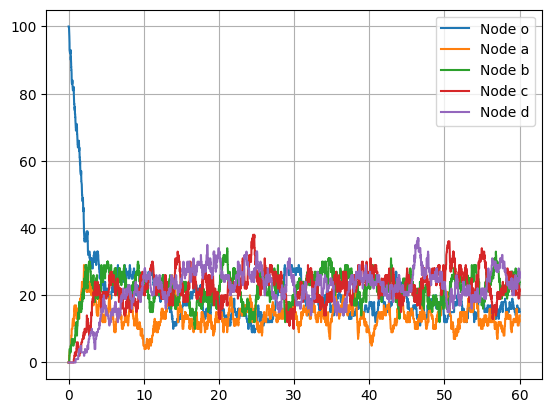

<Figure size 2400x1200 with 0 Axes>

In [44]:
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.grid(visible=True)
plt.plot(ttimes, pt)
plt.legend(dict_id.keys())
plt.figure(dpi=120, figsize=(20,10))

plt.show()

## Exercise 3


$$
\Lambda_{open} =
\begin{pmatrix}
0 & 3/4 & 3/8 & 0 & 0\\
0 & 0 & 1/4 & 1/4 &2/4\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
\begin{matrix}
o \\ a \\ b \\ c \\ d
\end{matrix}
$$

![openNet](openNet.png)

In [45]:
Lambda = [
    [0, 3/4, 3/8, 0, 0],
    [0, 0, 1/4, 1/4, 2/4],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
]

### Proportional Rate

Here we have an open network with a variable rate proportionally to the number of particles present in the node.

Given $\mathcal{N}_i(t)$ as the number of particles present in the node at moment $t$, the ration of each node will be given by $\mathcal{N}_i(t)\omega_i$

In [67]:
Lambda_ = Lambda
Lambda_[-1][-1] = 1
P = compute_P_matrix(Lambda)
w = compute_w(Lambda)

In [47]:
def simulateOpenNetVariableRate(P, w, max_time, w_entrance):
    nstates =  P.shape[0]
    #w_entrance = 10
    entrance_node = 0
    out_node = nstates-1
    w_d = 2
    w[-1] = w_d
    d = 0
    nparticles_node = [0] * nstates
    nparticles_time = [nparticles_node.copy()]
    ttime = [0]
    t_next = -np.log(np.random.rand())/w_entrance
    nparticles_node[entrance_node] += 1
    ttime.append(ttime[-1] + t_next)
    nparticles_time.append(nparticles_node.copy())
    add_particle = nstates
    #print(nparticles_node)
    while ttime[-1] < max_time:
        T_list = [ -np.log(np.random.rand())/(w[i]*nparticles_node[i]) if nparticles_node[i] > 0 else np.inf for i in range(nstates)]
        T_list.append(-np.log(np.random.rand())/w_entrance)
        #print(T_list)
        from_node = T_list.index((min(T_list)))
        #print(from_node)
        if from_node == add_particle:
            nparticles_node[entrance_node] += 1
        if from_node == out_node:
            nparticles_node[out_node] -= 1
            d+=1
        if from_node in range(nstates):
            nparticles_node[from_node] -= 1
            to_node = np.random.choice(nstates, p=P[from_node,:])
            nparticles_node[to_node] += 1
        nparticles_time.append(nparticles_node.copy())
        t_next = min(T_list)
        ttime.append(ttime[-1] + t_next)
        #print(nparticles_node)
    print("Particles ejected from the network:",d)
    return nparticles_time, ttime



*Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.*

Particles ejected from the network: 68


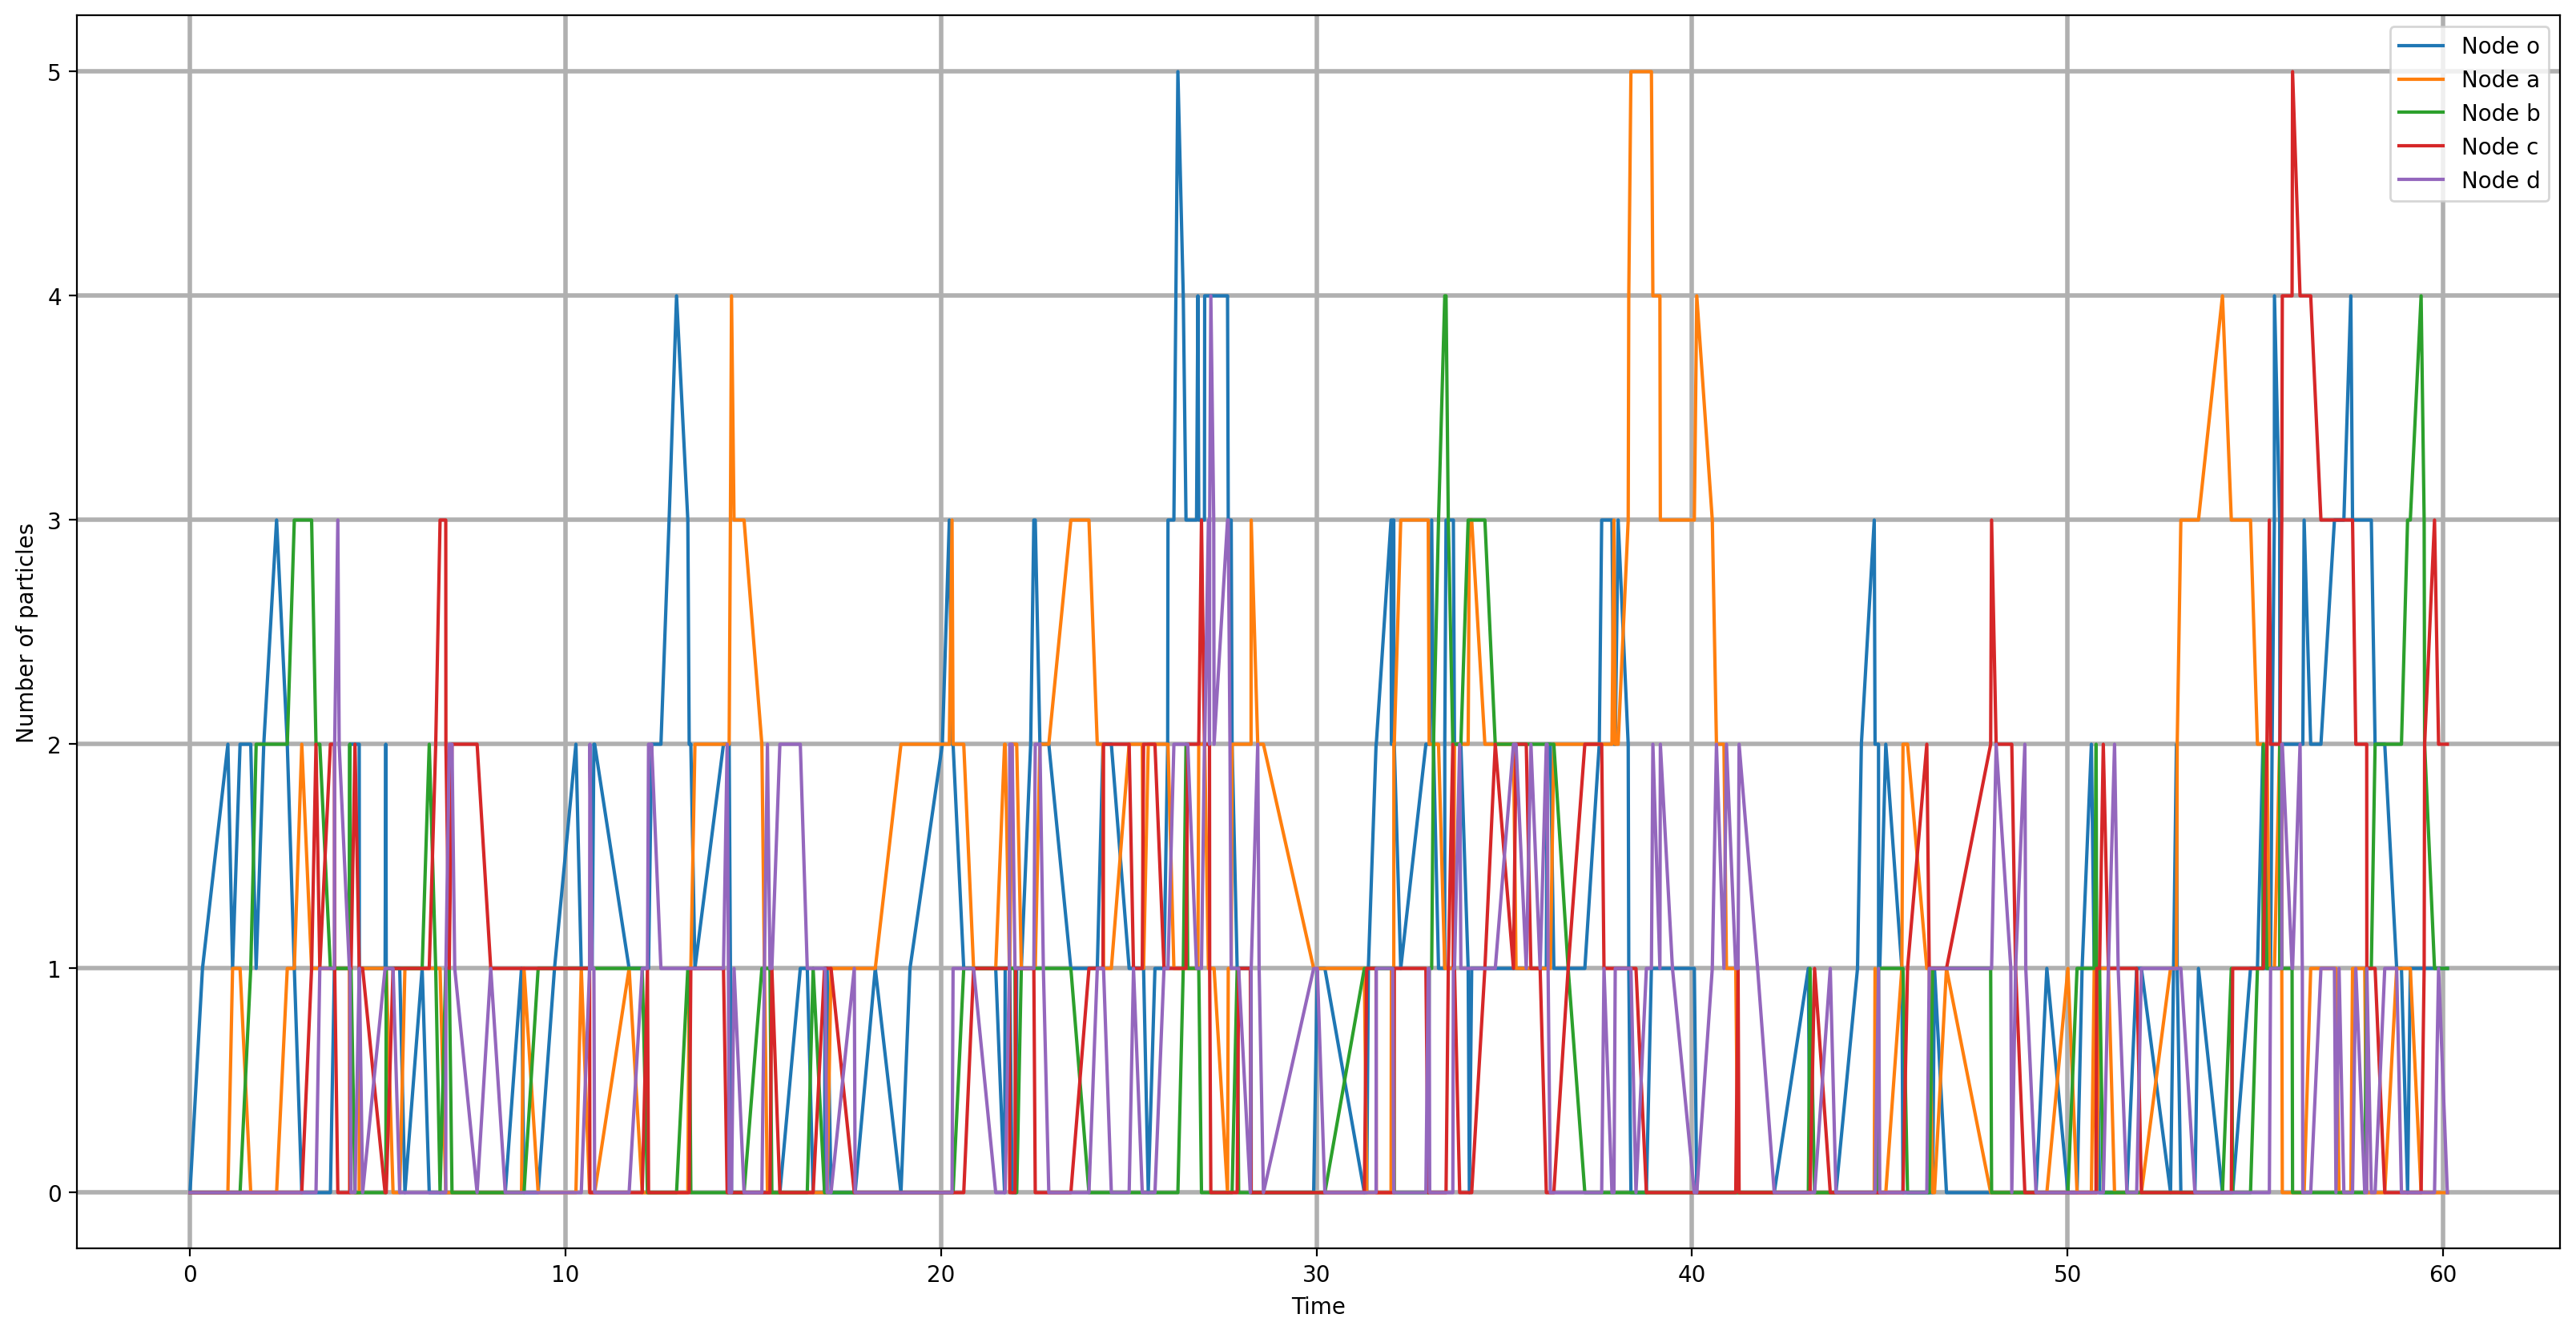

In [48]:
nt, t = simulateOpenNetVariableRate(P, w, max_time=60, w_entrance=1)
plt.figure(dpi=200, figsize=(20,10))
plt.grid(axis='both', linewidth=2, linestyle='-')
plt.plot(t, np.array(nt)[:,:])
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.legend(dict_id.keys())
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.savefig("proprate-input1.png")
plt.show()

*What is the largest input rate that the system can handle without blowing up?*

Particles ejected from the network: 56685


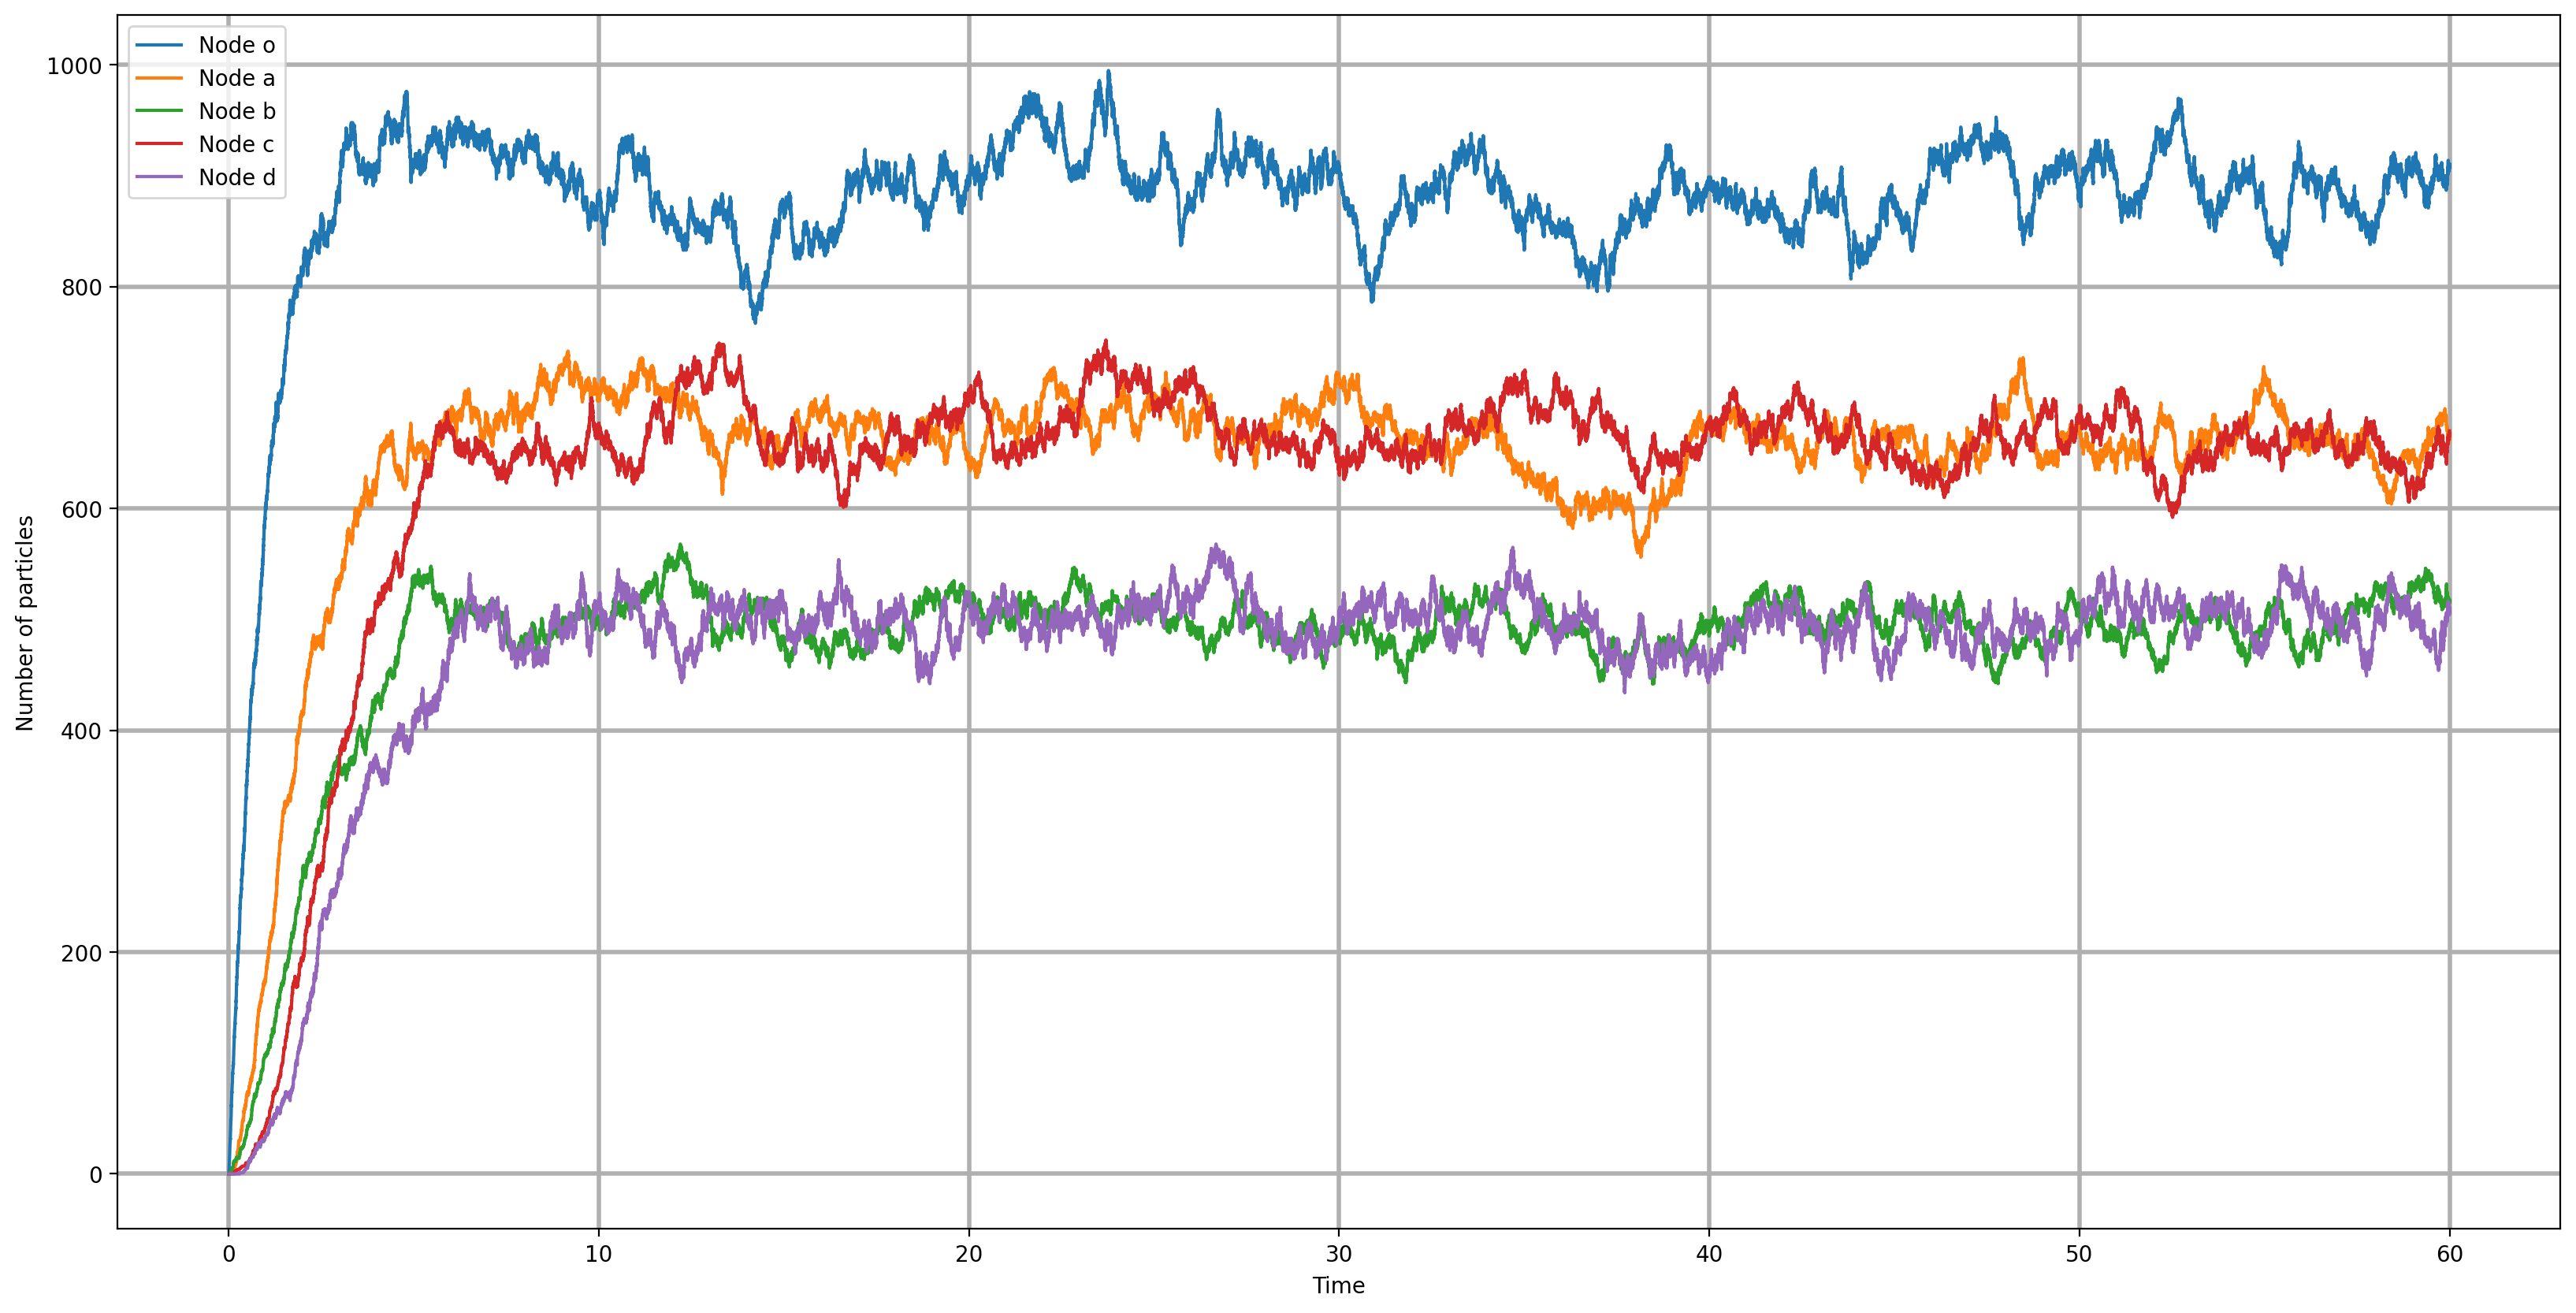

In [49]:
nt, t = simulateOpenNetVariableRate(P, w, max_time=60, w_entrance=1000)
plt.figure(dpi=200, figsize=(20,10))
plt.grid(axis='both', linewidth=2, linestyle='-')
plt.plot(t, np.array(nt)[:,:])
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.legend(dict_id.keys())
#plt.title("Input rate = 1000")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.savefig("proprate-input1000.png")
plt.show()

Because of the variable rate, that depends on the number of particles, the ingestion in the first node is easily managed when $\omega_o \mathcal{n}_o(t) \simeq r_{input}$.

### Fixed Rate

In [60]:
def simulateOpenNetFixedRate(P, w, max_time, w_entrance=1):
    nstates =  P.shape[0]
    entrance_node = 0
    out_node = nstates-1
    w_d = 2
    w[-1] = w_d
    nparticles_node = [0] * nstates
    nparticles_time = [nparticles_node.copy()]
    ttime = [0]
    t_next = -np.log(np.random.rand())/w_entrance
    nparticles_node[entrance_node] += 1
    ttime.append(ttime[-1] + t_next)
    nparticles_time.append(nparticles_node.copy())
    add_particle = nstates
    d = 0
    #print(nparticles_node)
    while ttime[-1] < max_time:
        T_list = [ -np.log(np.random.rand())/(w[i]) if nparticles_node[i] > 0 else np.inf for i in range(nstates)]
        T_list.append(-np.log(np.random.rand())/w_entrance)
        #print(T_list)
        from_node = T_list.index((min(T_list)))
        #print(from_node)
        if from_node == add_particle:
            nparticles_node[entrance_node] += 1
        if from_node == out_node:
            nparticles_node[out_node] -= 1
            d+=1
        if from_node in range(nstates):
            nparticles_node[from_node] -= 1
            to_node = np.random.choice(nstates, p=P[from_node,:])
            nparticles_node[to_node] += 1
        nparticles_time.append(nparticles_node.copy())
        t_next = min(T_list)
        ttime.append(ttime[-1] + t_next)
        #print(nparticles_node)
    print("Particles ejected from the network:",d)
    return nparticles_time, ttime

*Simulate the system for 60 time units and plot the evolution of number of particles in each node over time.*

Particles ejected from the network: 50


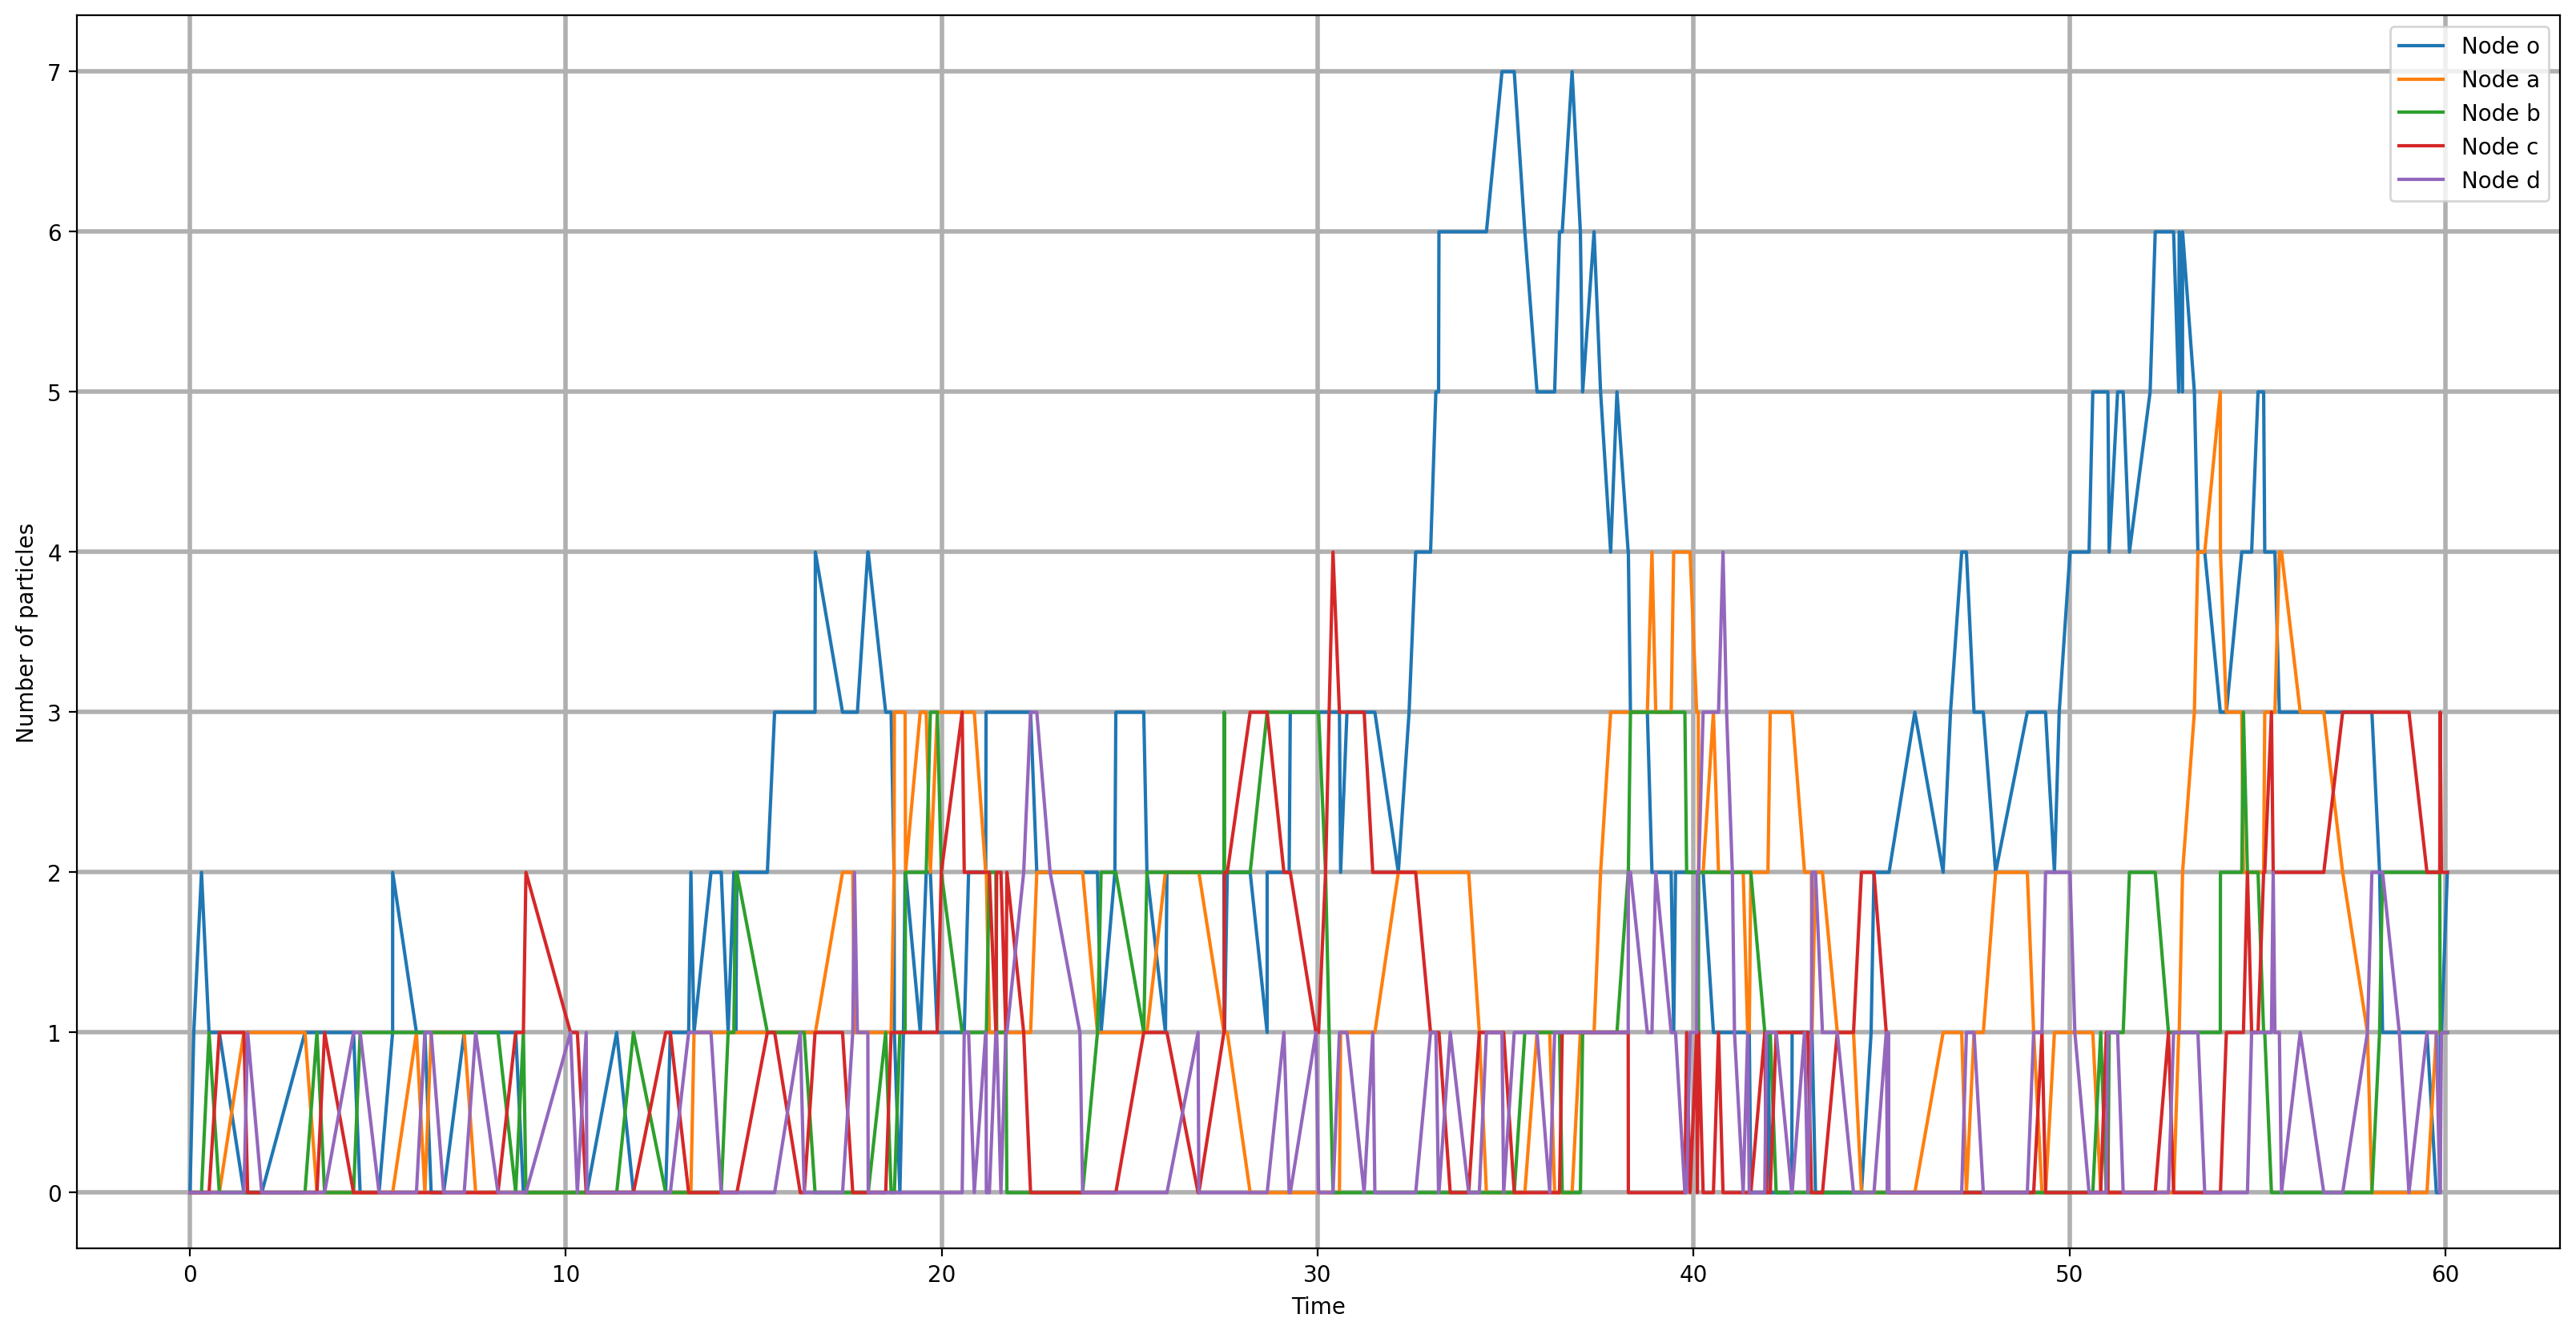

In [61]:
nt, t = simulateOpenNetFixedRate(P, w, max_time=60, w_entrance=1)
plt.figure(dpi=200, figsize=(20,10))
plt.grid(axis='both', linewidth=2, linestyle='-')
plt.plot(t, np.array(nt)[:,:])
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.legend(dict_id.keys())
#plt.title("Input rate = 1")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.savefig("fixrate-input1.png")
plt.show()

*What is the largest input rate that the system can handle without blowing up? Why is this different from the other case?*

Particles ejected from the network: 63


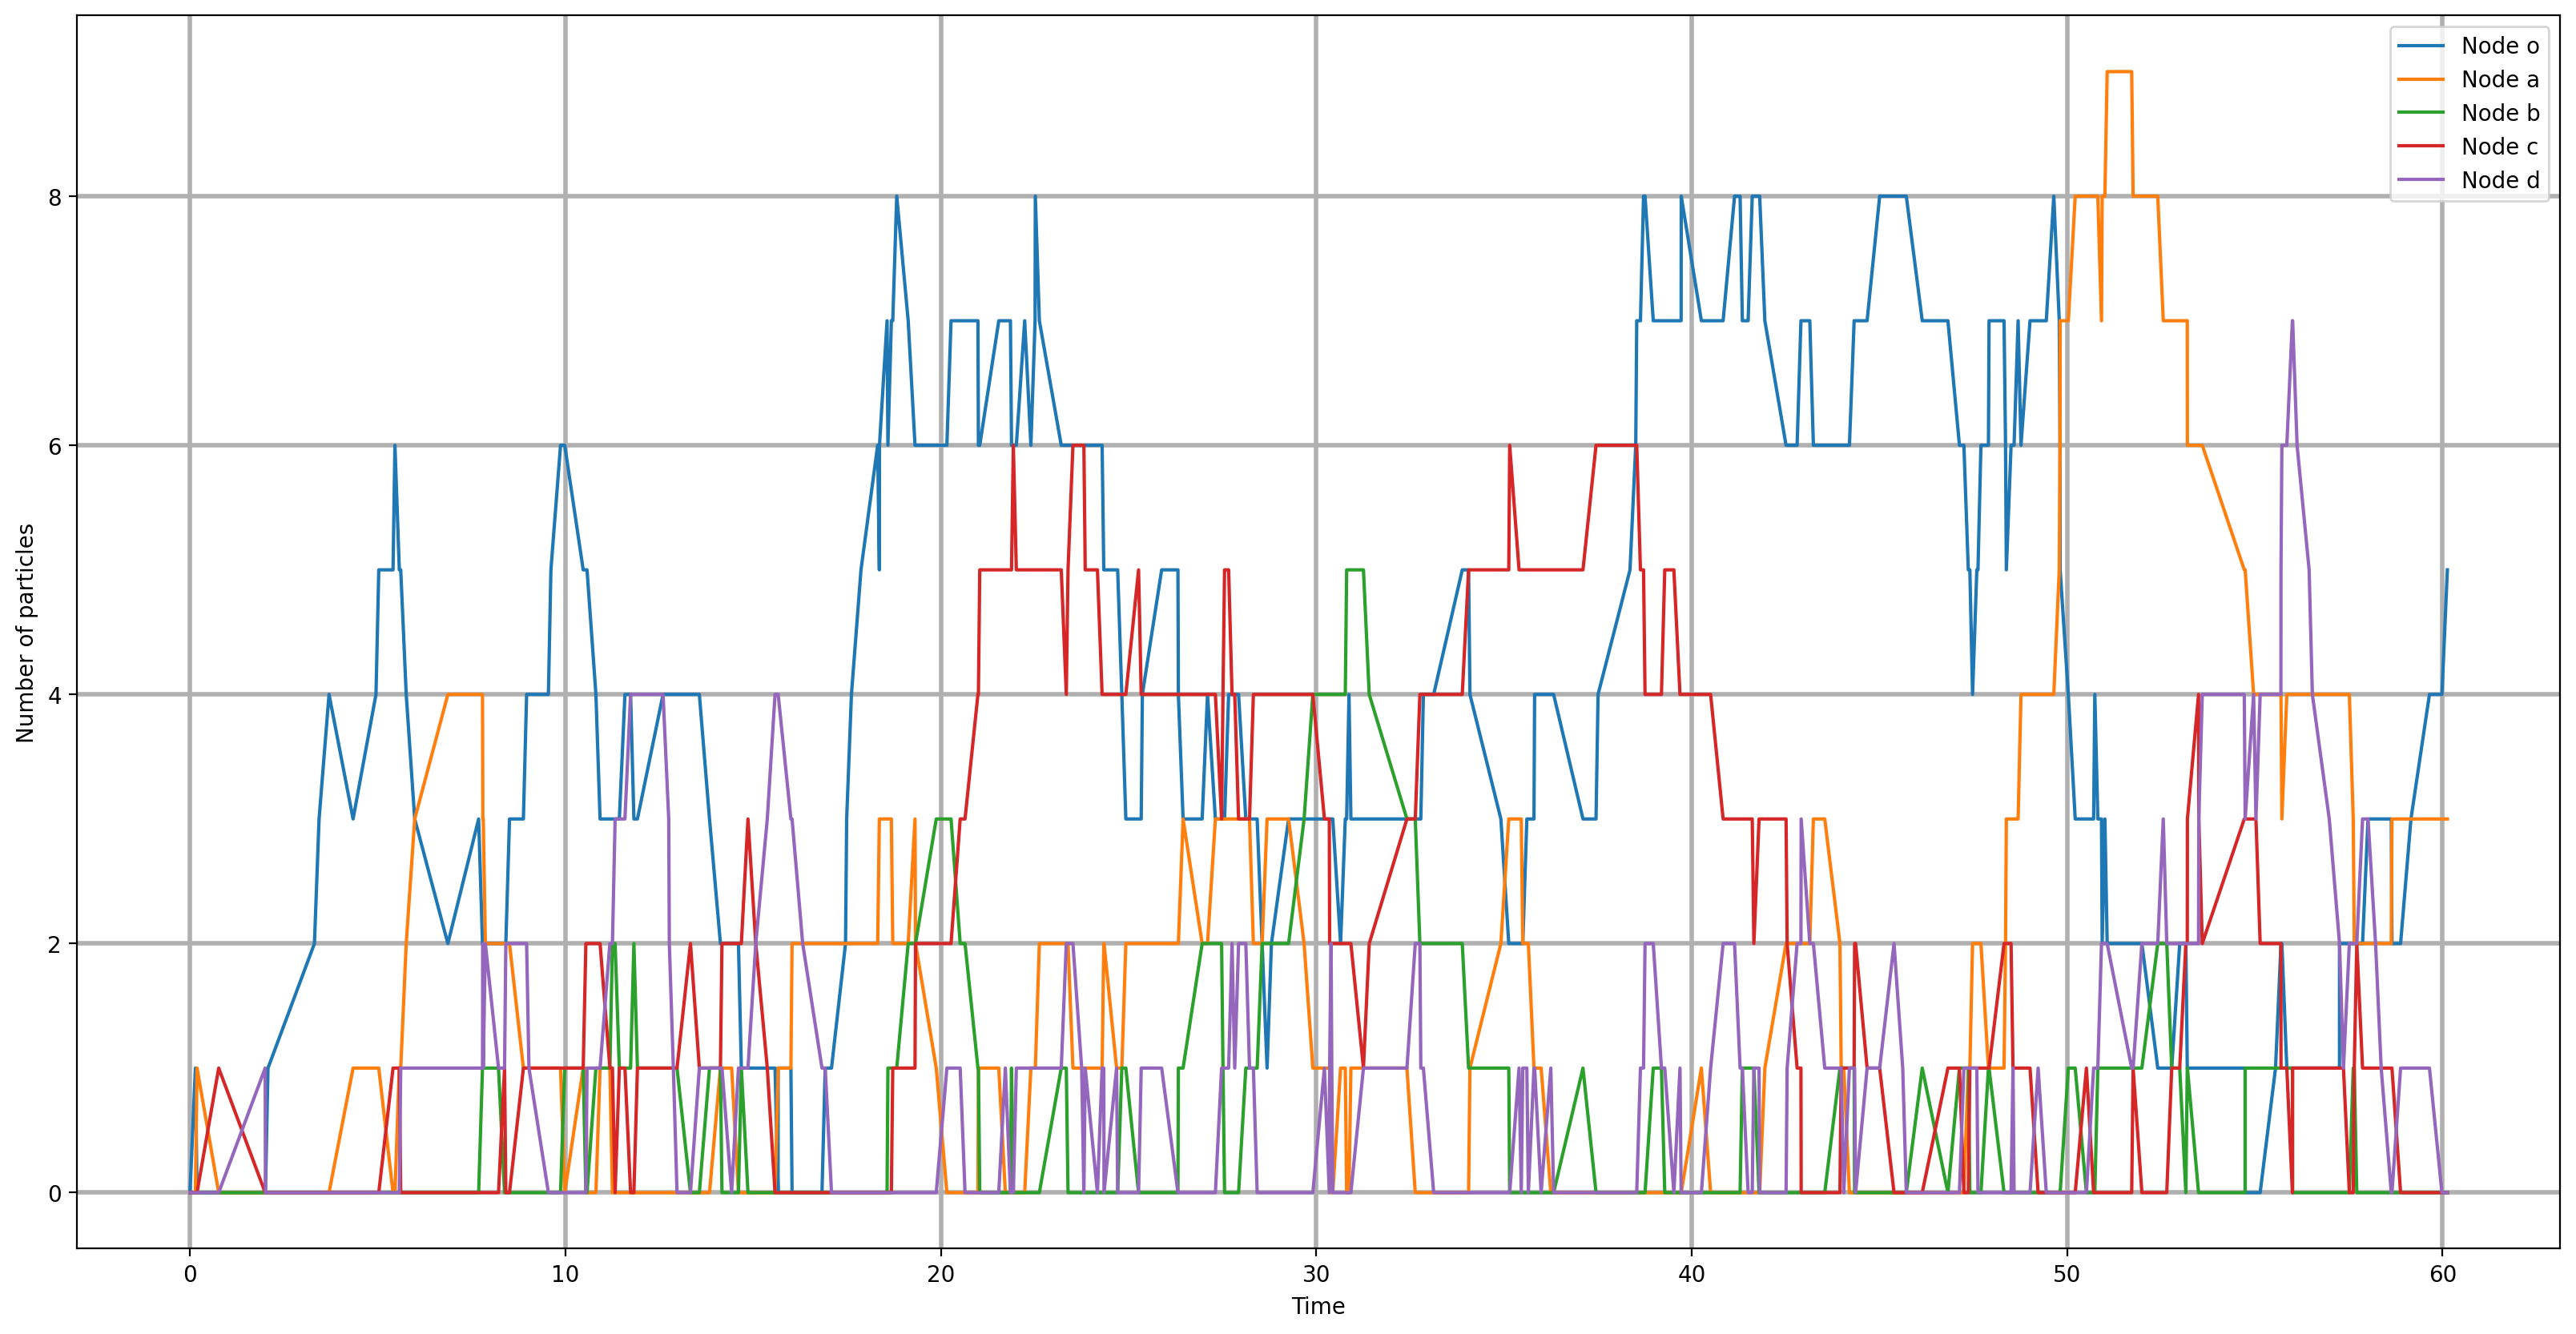

In [64]:
nt2, t2 = simulateOpenNetFixedRate(P, w, max_time=60, w_entrance=w[0]-0.1)
plt.figure(dpi=200, figsize=(20,10))
plt.grid(axis='both', linewidth=2, linestyle='-')
plt.plot(t2, np.array(nt2)[:,:])
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.legend(dict_id.keys())
#plt.title("Input rate = w_o - 0.1")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.savefig("fixrate-inputW-.png")
plt.show()

Particles ejected from the network: 59


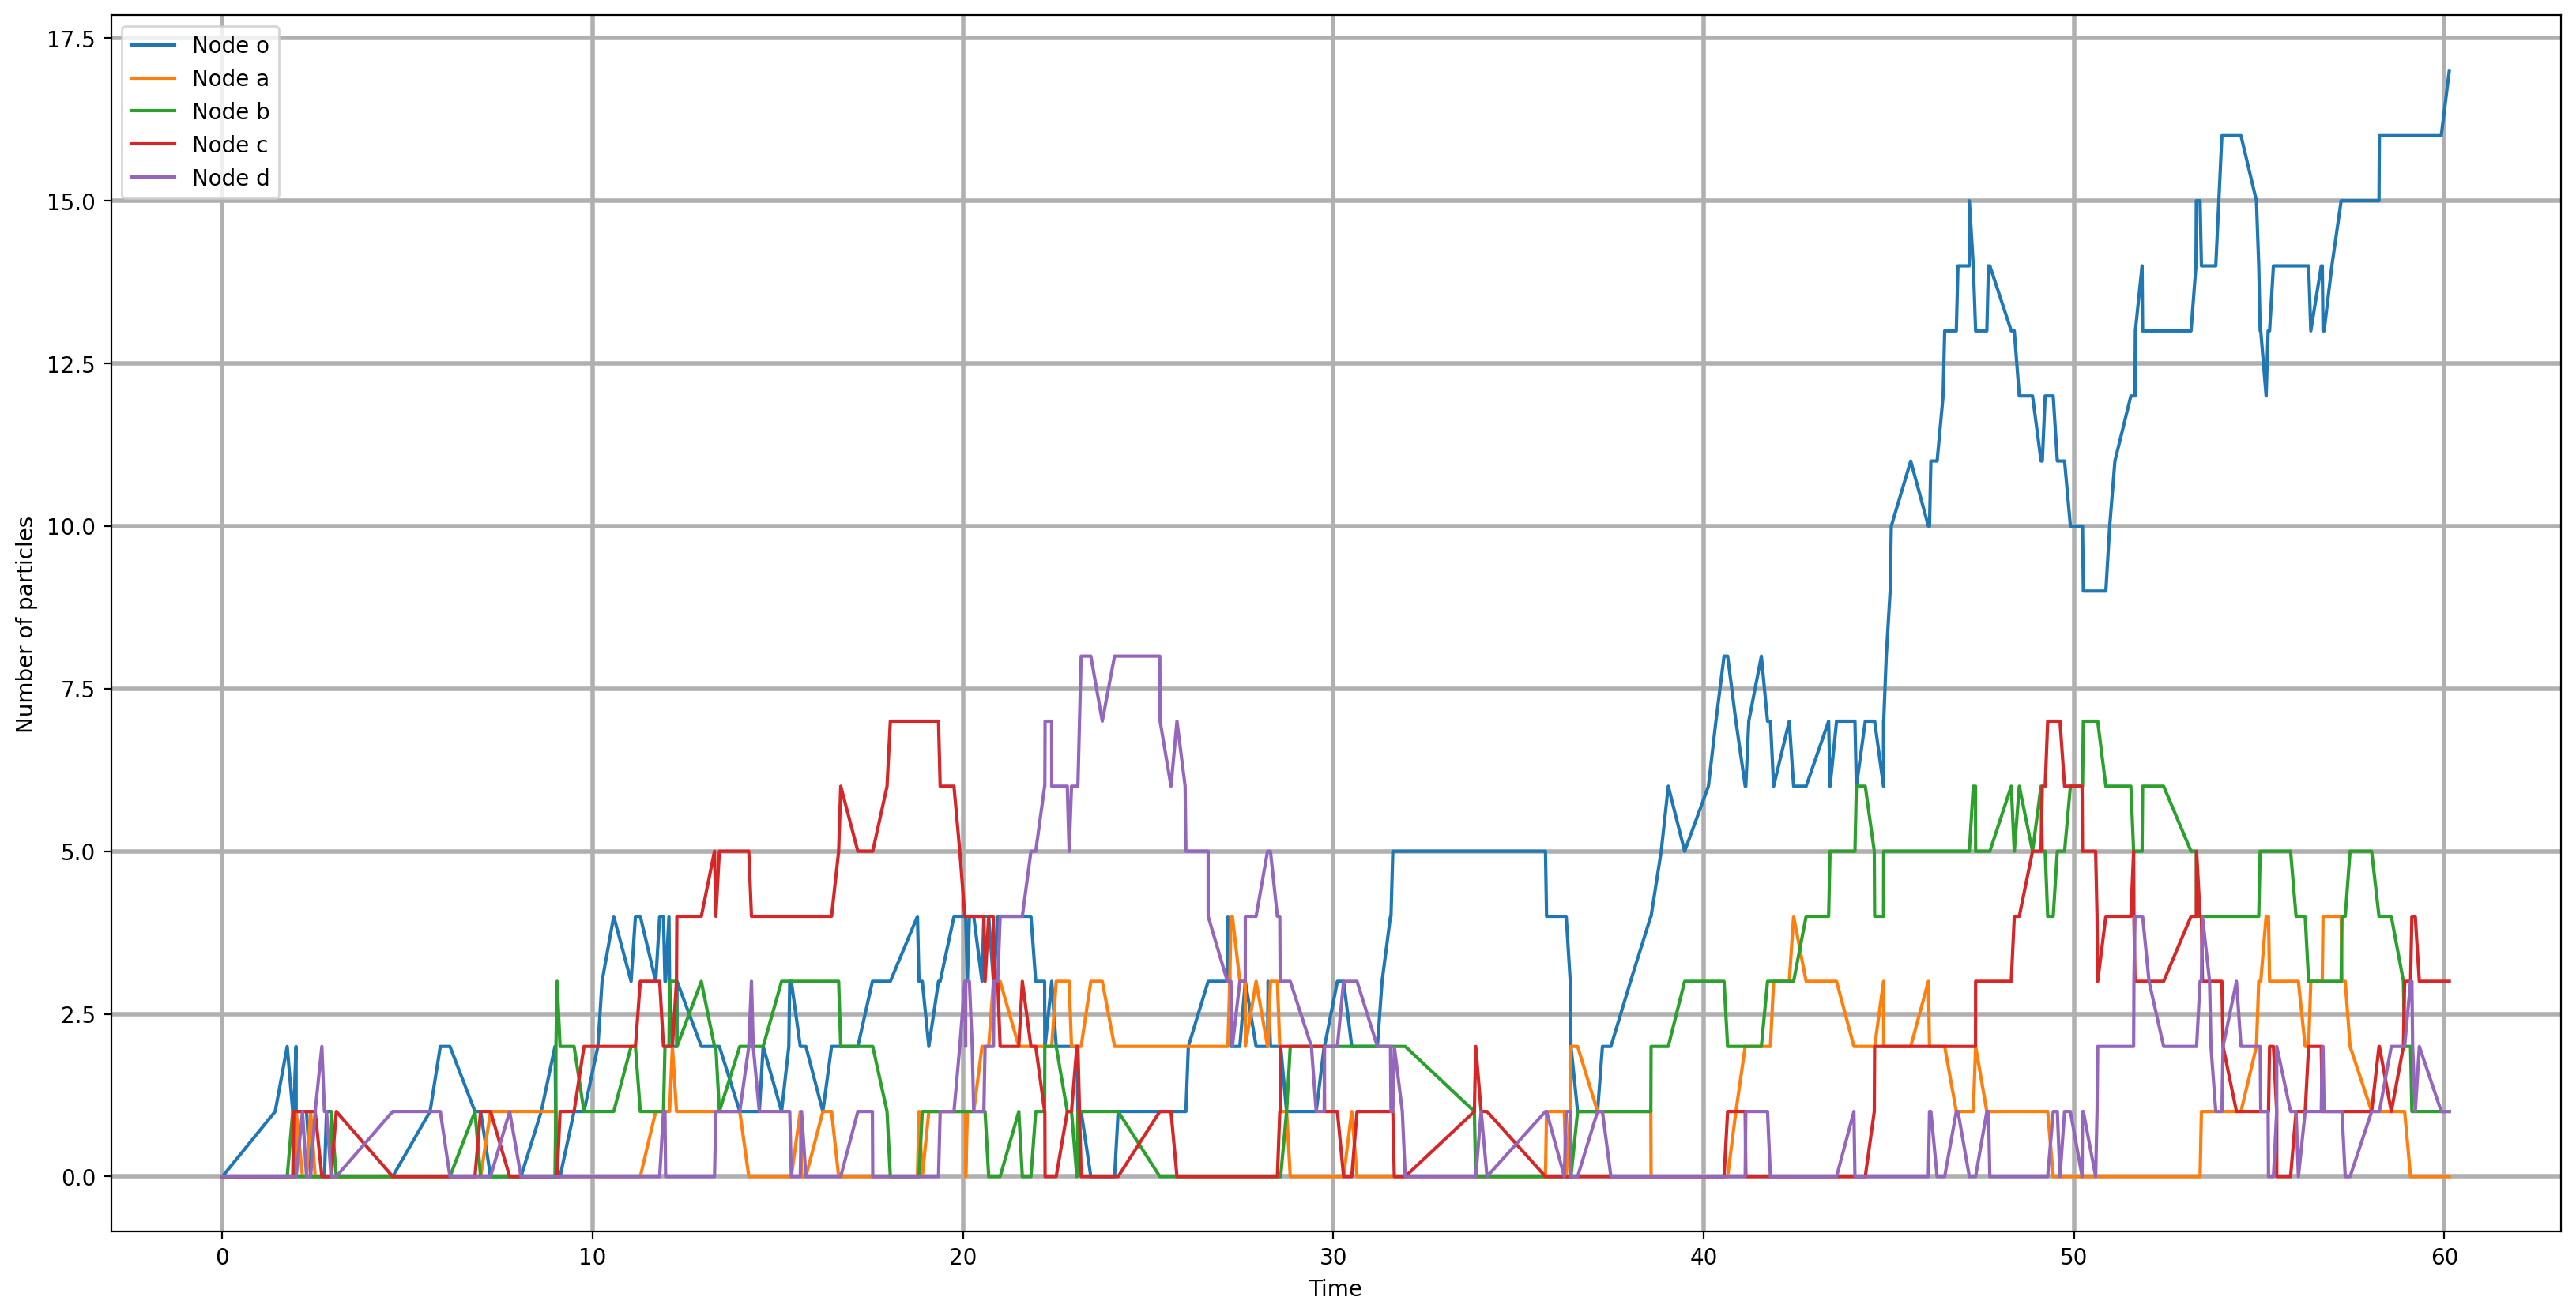

In [73]:
nt3, t3 = simulateOpenNetFixedRate(P, w, max_time=60, w_entrance=w[0]+.1)
plt.figure(dpi=200, figsize=(20,10))
plt.grid(axis='both', linewidth=2, linestyle='-')
plt.plot(t3, np.array(nt3)[:,:])
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.legend(dict_id.keys())
#plt.title("Input rate = w_o + 0.1")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.savefig("fixrate-inputW+.png")
plt.show()

Particles ejected from the network: 42


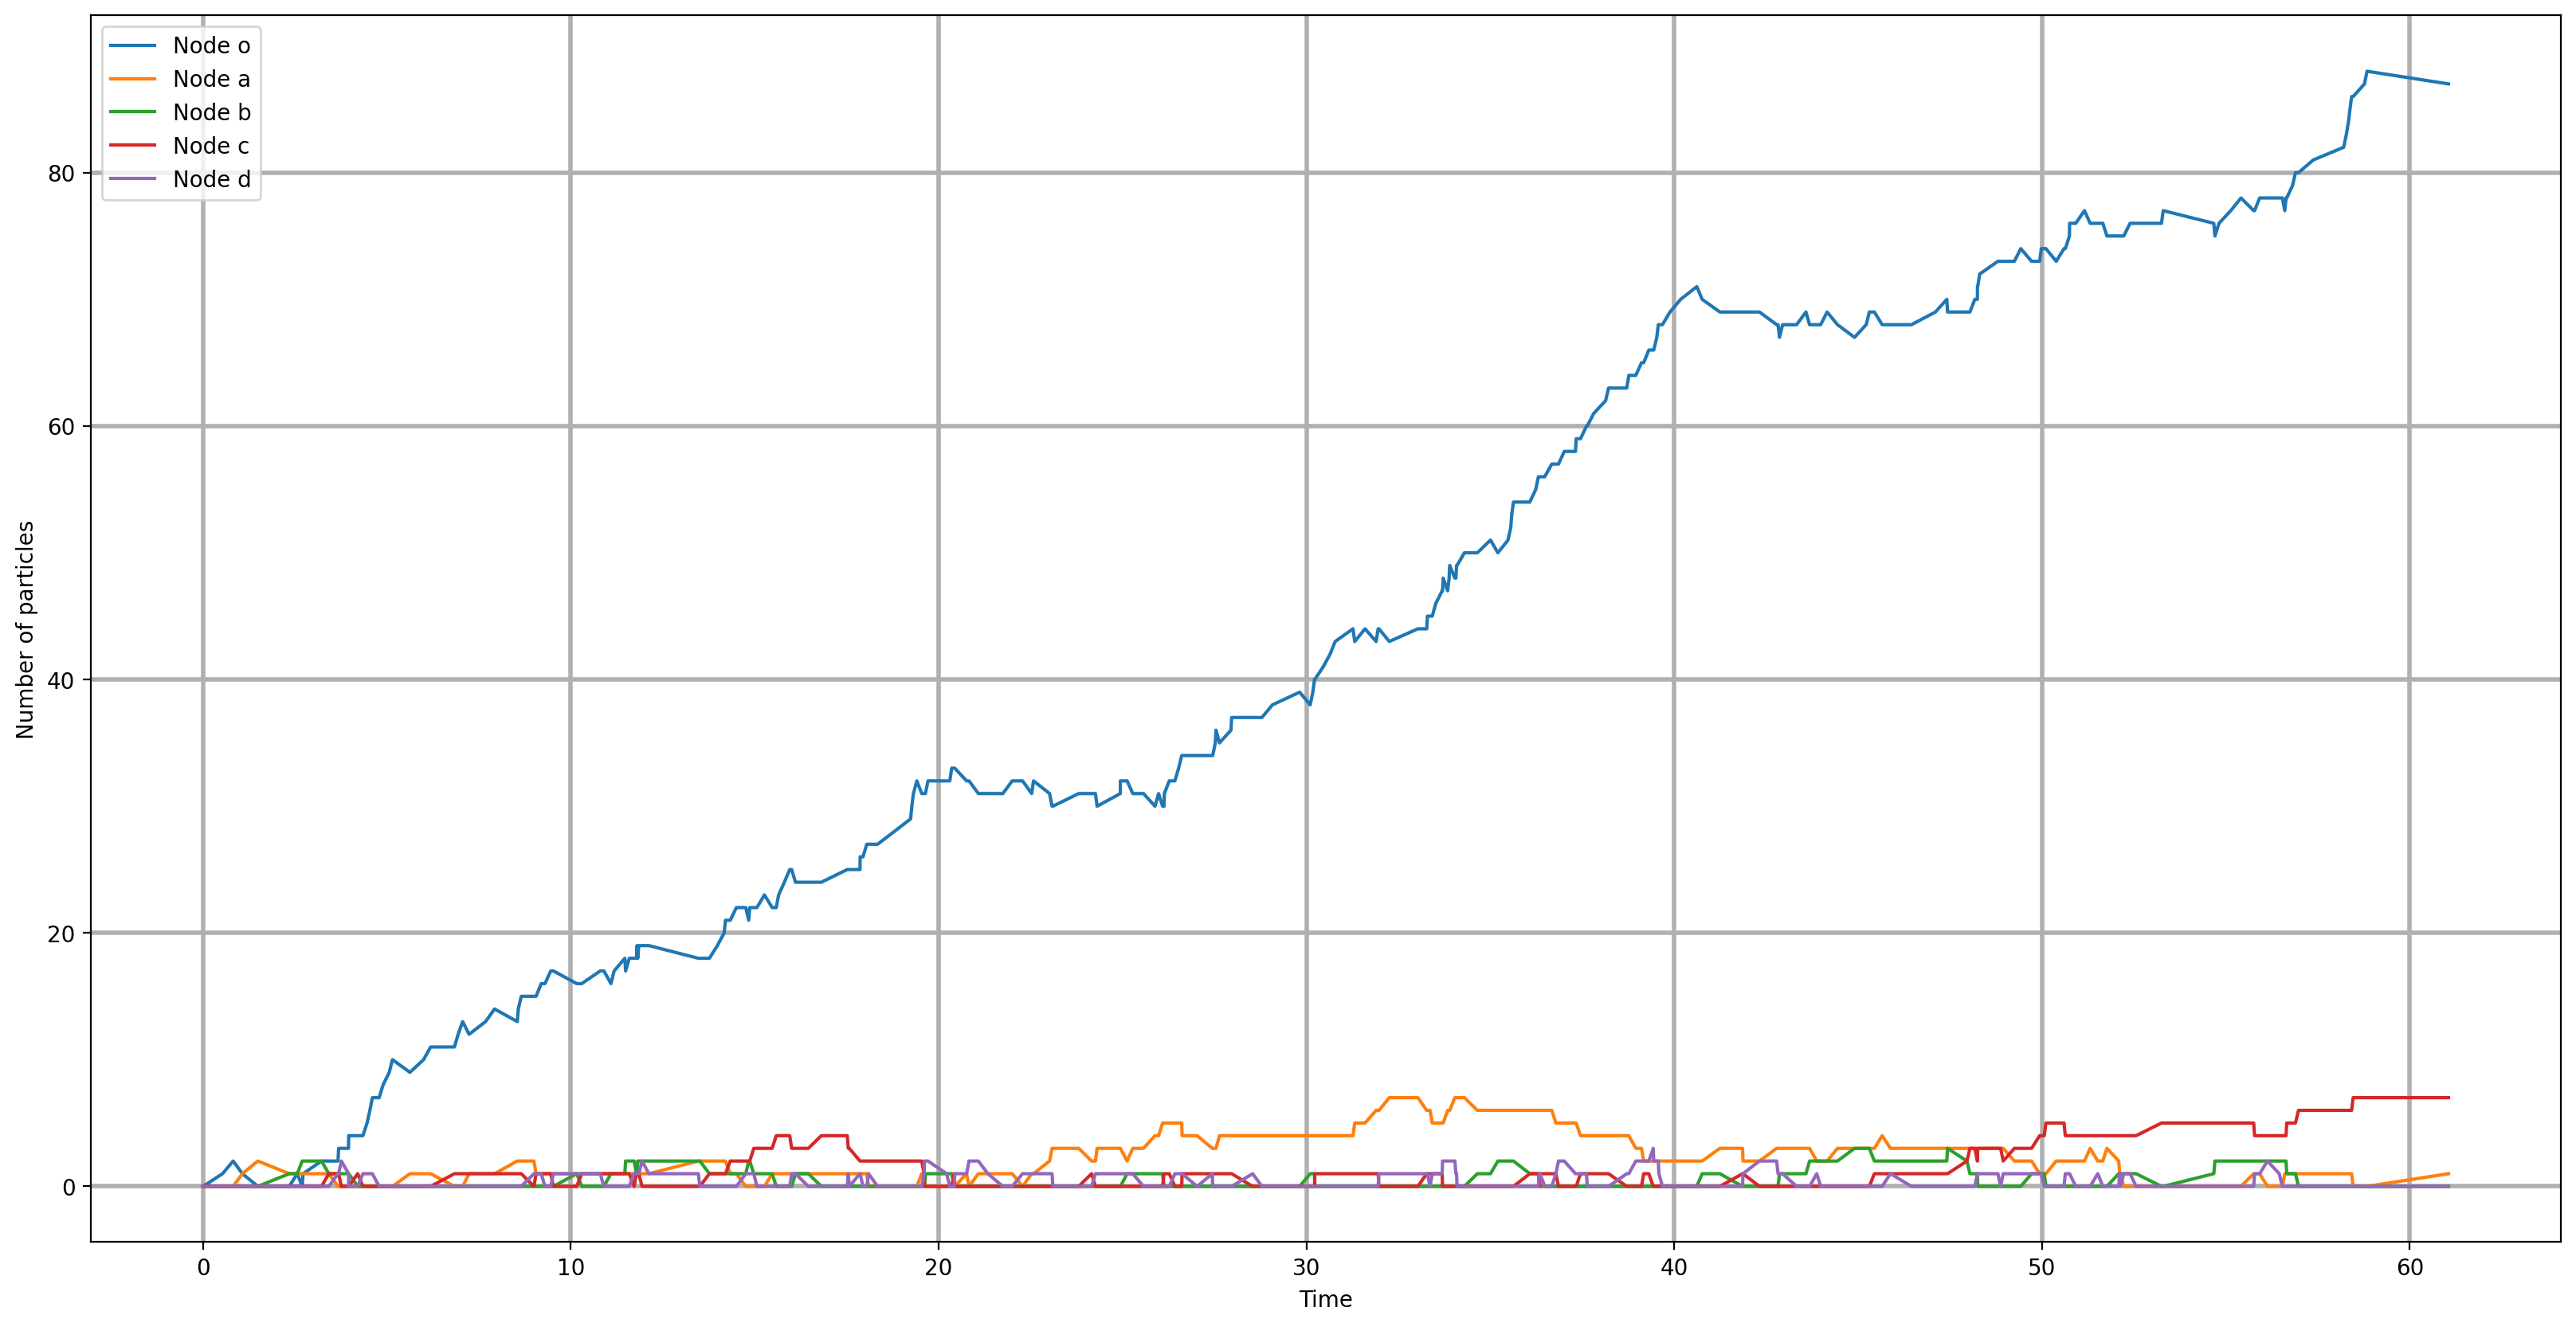

In [70]:
nt4, t4 = simulateOpenNetFixedRate(P, w, max_time=60, w_entrance=2)
plt.figure(dpi=200, figsize=(20,10))
plt.grid(axis='both', linewidth=2, linestyle='-')
plt.plot(t4, np.array(nt4)[:,:])
dict_id = {'Node o': u'blue', 'Node a': u'red', 'Node b': u'green', 'Node c': u'orange', 'Node d': u'purple'}
plt.legend(dict_id.keys())
#plt.title("Input rate = 2")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.savefig("fixrate-input2.png")
plt.show()

As we can see, given an input rate $r_{input} > \omega_o$ the network will start to blowing up the number of particles.

In $r_{input} \le \omega_o$ cases the network can manage the number of particles without problem.